In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
file_gt = '/home/anna/data_19Nov2022/real_test.h5'

In [3]:
gt_rec = h5py.File(file_gt, 'r')

In [4]:
multi_GT = gt_rec['recon_multisegment']
linear_GT = gt_rec['recon_linear']

In [5]:
batch = 0
file_input = f'/home/anna/ResultsSignalDA/MIAvalidation/reconstruction//MIAstyleLinear__2022-12-03/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'

rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']

In [6]:
def scale(im):
    sorted_int_values = np.sort(np.reshape(im, [-1]))
    low5, high95 = int(len(sorted_int_values) * 0.025), int(len(sorted_int_values) * 0.975)
#     im_clipped = np.clip(im, a_min=sorted_int_values[low5], a_max=sorted_int_values[high95])
    im_clipped = im
    im_clipped /= np.max(im_clipped)
    im_clipped = np.clip(im_clipped, -0.2, 2)
    return im_clipped

In [7]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import cv2

def get_metrics(gt, pred):
    metrics = {}
    metrics['SSIM'] = ssim(pred, gt, data_range=gt.max() - gt.min())
    metrics['PSNR'] = cv2.PSNR(gt, pred)
    metrics['MAE'] = np.mean(abs(gt - pred))
    metrics['RMSE'] = mean_squared_error(gt, pred)
    
    return metrics

In [11]:
def get_images(i, batch, plot=False):
    gt = scale(multi_GT[batch*256+i])
    gt_lin = scale(linear_GT[batch*256+i])
    en = scale(np.rot90(rec_en[i])[:, ::-1])
    bp = scale(np.rot90(rec_bp[i])[:, ::-1])
    
    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(10,4))
        axs[0].imshow(gt)
        axs[0].set_title('GT')
        axs[1].imshow(gt_lin)
        axs[1].set_title('BM linear')
        axs[2].imshow(en)
        axs[2].set_title('EN')
        axs[3].imshow(bp)
        axs[3].set_title('BP')
    
    metrics_en = get_metrics(gt, en)
    metrics_bp = get_metrics(gt, bp)
    metrics_lin = get_metrics(gt, gt_lin)
    
    return metrics_en, metrics_bp, metrics_lin

In [10]:
metrics_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': []}
metrics_bp_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': []}
metrics_lin_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': []}

n_batches = 55
n = 256
for batch in range(n_batches):
    # file_input = f'/home/anna/ResultsSignalDA/MIAvalidation/reconstruction//MIAstyleLinear__2022-12-03/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
    file_input = f'/home/anna/ResultsSignalDA/MIAvalidation/reconstruction//MIAstyleLinear__2022-12-03/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
    rec = h5py.File(file_input, 'r')
    rec_bp = rec['BackProjection']
    rec_en = rec['ElasticNet 1e-5']
    
    pbar = tqdm(range(n))
    for i in pbar:
        metrics_en, metrics_bp, metrics_lin = get_images(i, batch)
        for k in metrics_en:
            metrics_en_total[k].append(metrics_en[k])
            metrics_bp_total[k].append(metrics_bp[k])
            metrics_lin_total[k].append(metrics_lin[k])
        pbar.set_description(f"[{batch}]: SSIM_en={np.mean(metrics_en_total['SSIM']):.2f}, SSIM_lin={np.mean(metrics_lin_total['SSIM']):.2f}")

[23]: SSIM_en=0.31, SSIM_lin=0.61:  41%|████      | 105/256 [00:06<00:09, 16.16it/s]


KeyboardInterrupt: 

In [13]:
print('Elastic Net')
for k in metrics_en_total:
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nBackProjection')
for k in metrics_bp_total:
    m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nLinear BM')
for k in metrics_bp_total:
    m, s = np.mean(metrics_lin_total[k]), np.std(metrics_lin_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')

Elastic Net
SSIM: 0.265 +/- 0.156
PSNR: 69.227 +/- 4.386
MAE: 0.064 +/- 0.039
RMSE: 0.013 +/- 0.016

BackProjection
SSIM: 0.259 +/- 0.133
PSNR: 72.251 +/- 3.651
MAE: 0.050 +/- 0.028
RMSE: 0.006 +/- 0.007

Linear BM
SSIM: 0.590 +/- 0.113
PSNR: 75.257 +/- 3.526
MAE: 0.033 +/- 0.018
RMSE: 0.003 +/- 0.003


In [15]:
len(metrics_lin_total[k])

14010

({'SSIM': 0.1469288777361133,
  'PSNR': 67.16483430082702,
  'MAE': 0.07444437,
  'RMSE': 0.012490992015964281},
 {'SSIM': 0.23490357155802688,
  'PSNR': 71.06199636374652,
  'MAE': 0.049895454,
  'RMSE': 0.0050919100761259335},
 {'SSIM': 0.6070844997952916,
  'PSNR': 74.38505090379262,
  'MAE': 0.031570446,
  'RMSE': 0.002369055692851532})

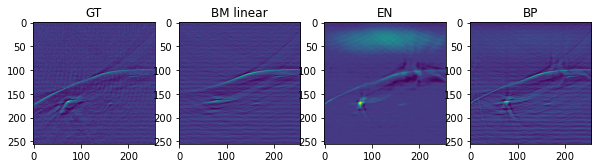

In [18]:
batch = 53
i = 100

file_input = f'/home/anna/ResultsSignalDA/MIAvalidation/reconstruction//MIAstyleLinear__2022-12-03/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']
    
get_images(i, batch, True)